In [1]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm



In [2]:
# Transforms

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
                                       ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [3]:
# download data
train = datasets.MNIST('./data',train=True,transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform =test_transforms, download=True)

In [4]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

# torch.manual_seed(SEED)

# if cuda:
#   torch.cuda.manual_seed(SEED)

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


torch.Size([128, 1, 28, 28]) torch.Size([1, 28, 28])
(28, 28)


Text(0.5, 1.0, '3')

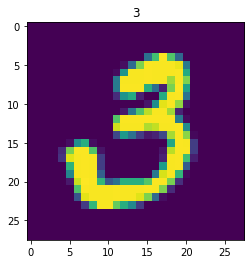

In [5]:
# Visualize Data

dataiter = iter(train_loader)
images,labels = dataiter.next()

print(images.shape, images[0].shape)

print(images[0].numpy().squeeze().shape) # squeeze removes the channel value. 
%matplotlib inline
plt.imshow(images[0].numpy().squeeze())
plt.title(labels[0].item()) #item converts from tensor to value

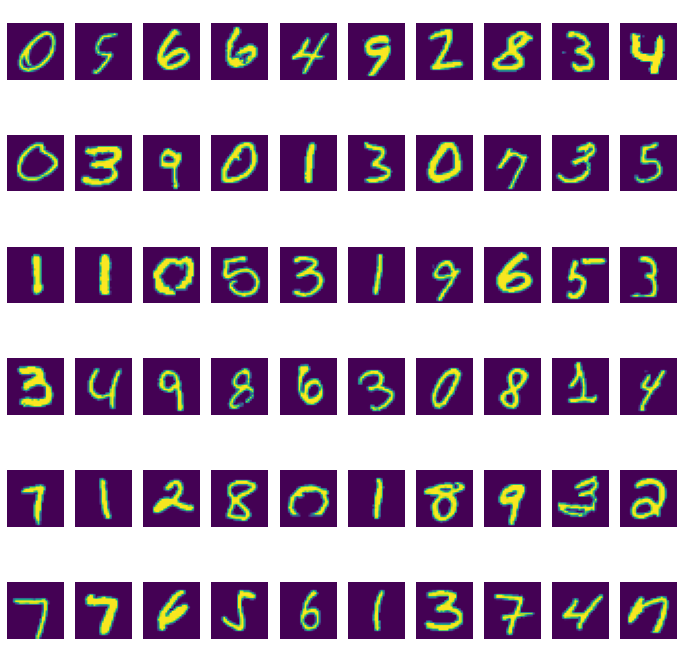

In [6]:
# visualize data in grid format

figure = plt.figure(figsize=(12,12))
num_of_images = 60

for index in range(1, num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze())
  plt.title(labels[index].item(),color='w')

In [7]:
# Model Architecture

dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() ,
            nn.Dropout(dropout_value)
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value) 
        ) # output_size = 3

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )


        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 5

    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)
        x = self.convblock10(x)

        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 10,

In [8]:
# Train Function

# Train and Test Functuions
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch):
  train_losses = []
  train_acc = []
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  return (train_acc,train_losses)



In [11]:
# Test Function

def test(model, device, test_loader):
    test_losses = []
    test_acc = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return (test_acc,test_losses)

In [17]:


# Train the model with lr scheduler. 

from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.05)



comb_train_losses = []
comb_train_acc    = []
comb_test_losses  = []
comb_test_acc     = []
EPOCHS = 10
for epoch in range(EPOCHS):
    
    print("EPOCH:", epoch)
    print('learning rate ', scheduler.get_lr())
    train_ac, train_los = train(model, device, train_loader, optimizer, epoch)
    scheduler.step()    
    test_ac, test_los = test(model, device, test_loader)

    comb_train_losses.extend(train_los)
    comb_train_acc.extend(train_ac)
    comb_test_losses.extend(test_los)
    comb_test_acc.extend(test_ac)



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


Loss=0.11305608600378036 Batch_id=468 Accuracy=87.07: 100%|██████████| 469/469 [00:12<00:00, 37.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0649, Accuracy: 9831/10000 (98.31%)

EPOCH: 1
learning rate  [0.01]


Loss=0.05645082890987396 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9889/10000 (98.89%)

EPOCH: 2
learning rate  [0.01]


Loss=0.04939796403050423 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:12<00:00, 37.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9912/10000 (99.12%)

EPOCH: 3
learning rate  [0.01]


Loss=0.018322182819247246 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:12<00:00, 37.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9917/10000 (99.17%)

EPOCH: 4
learning rate  [0.01]


Loss=0.0890662670135498 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:12<00:00, 37.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9904/10000 (99.04%)

EPOCH: 5
learning rate  [0.01]


Loss=0.025717658922076225 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 36.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.005518140271306038 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:12<00:00, 36.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.08424791693687439 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 36.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.012677856720983982 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.016594642773270607 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 37.22it/s]



Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)



In [18]:
# Save the model

Text(0.5, 1.0, 'Test Accuracy')

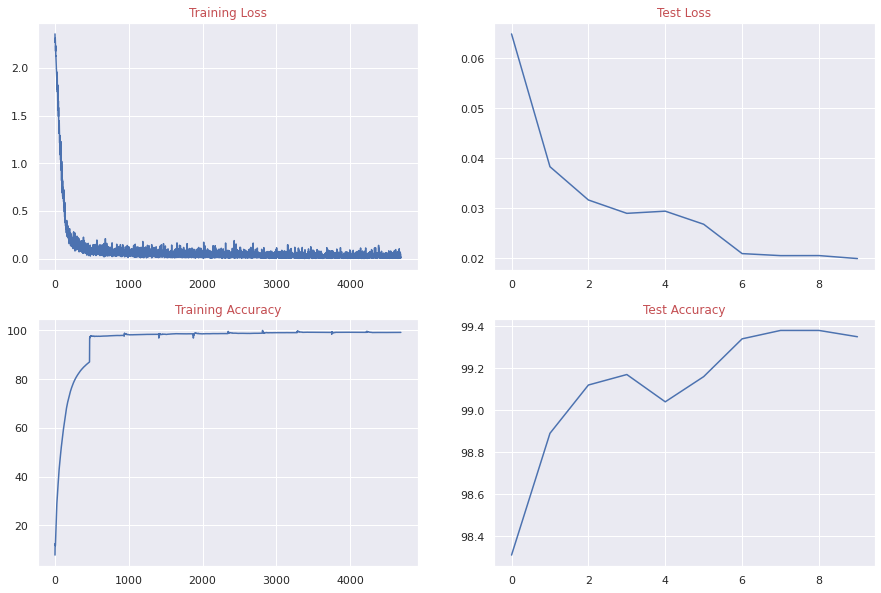

In [19]:
# Plot Error and accuracy
# Plot the accuracy and loss curves. 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# plt.style.use("dark_background")
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(comb_train_losses)
axs[0, 0].set_title("Training Loss",color='r')
axs[1, 0].plot(comb_train_acc)
axs[1, 0].set_title("Training Accuracy",color='r')
axs[0, 1].plot(comb_test_losses)
axs[0, 1].set_title("Test Loss",color='r')
axs[1, 1].plot(comb_test_acc)
axs[1, 1].set_title("Test Accuracy", color='r')

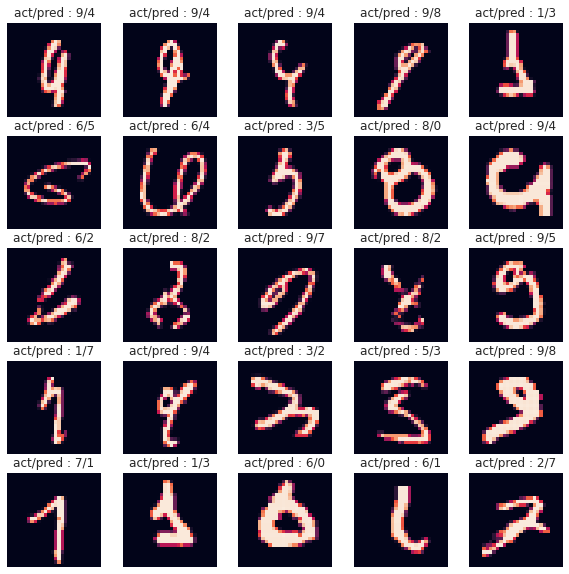

In [20]:
# Visualize the misclassified images
model.eval()

figure = plt.figure(figsize=(10,10))
num_of_images = 25
index=1


with torch.no_grad():
  for data,target in test_loader:
    data,target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1,keepdim=True)
    act = target.view_as(pred)
    bool_vec = ~pred.eq(act) # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa

    # now extract the index number from the tensor which has 'true' 
    idx = list(np.where(bool_vec.cpu().numpy())[0])

    if idx: # if not a blank list
      idx_list = idx
      # print(data[idx_list[0]].shape)
      if index < num_of_images+1:
            
          plt.subplot(5,5,index)
          plt.axis('off')
          titl = 'act/pred : ' + str(target[idx[0]].cpu().item()) + '/' + str(pred[idx[0]].cpu().item())
          plt.imshow(data[idx[0]].cpu().numpy().squeeze()) # prints the 1st index of each batch. 
          plt.title(titl)
          index+=1


# MODULAR

In [33]:
# Modular PRogramming

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm


class Trainer():
  '''Trainer Classe '''
  
  def __init__(self,model,device,train_loader,test_loader,optimizer,epoch,schedul):
    self.model = model
    self.device= device
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.optimizer = optimizer
    self.epoch = epoch
    self.scheduler = schedul


  def train(self,l1_lambda=0, l2_lambda=0):

    self.l1_lambda = l1_lambda
    self.l2_lambda = l2_lambda

    comb_train_losses = []
    comb_train_acc    = []
    comb_test_losses  = []
    comb_test_acc     = []
    # EPOCHS = 10
    for epoch in range(self.epoch):
        
        print("EPOCH:", epoch)
        print('learning rate ', self.scheduler.get_lr())

        # trainer = Trainer(model,device,train_loader,test_loader,optimizer,epoch)

        train_ac, train_los = trainer.train_mod()
        scheduler.step()    
        test_ac, test_los = trainer.test_mod()

        comb_train_losses.extend(train_los)
        comb_train_acc.extend(train_ac)
        comb_test_losses.extend(test_los)
        comb_test_acc.extend(test_ac)
    return ((comb_train_acc,comb_train_losses),(comb_test_acc,comb_test_losses)) 

  def train_mod(self):

    train_losses = []
    train_acc = []
    
    self.model.train()
    pbar = tqdm(self.train_loader)

    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(self.device), target.to(self.device)

      # Init
      self.optimizer.zero_grad()

      # Predict
      y_pred = self.model(data)

      # Calculate loss

      criterion = F.nll_loss(y_pred, target)

      if self.l1_lambda > 0:
          # l1 regularization
          l1_reg_loss = sum([torch.sum(abs(param)) for param in model.parameters()])

          loss = criterion + self.l2_lambda * l1_reg_loss
      else:
          loss = criterion

      # loss = criterion
      
      train_losses.append(loss)

      # Backpropagation
      loss.backward()
      self.optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_acc.append(100*correct/processed)
    return (train_acc,train_losses)



  def test_mod(self):
    test_losses = []
    test_acc = []
    self.model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in self.test_loader:
            data, target = data.to(self.device), target.to(self.device)
            output = self.model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return (test_acc,test_losses)


    

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# plt.style.use("dark_background")

def plot_metrics(train_metric,test_metric):
  (train_acc, train_losses) = train_metric
  (test_acc, test_losses) = test_metric


  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss",color='r')
  axs[1, 0].plot(train_acc[500:])
  axs[1, 0].set_title("Training Accuracy",color='r')
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss",color='r')
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy", color='r')


In [52]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

metric_values = {}
models={}



In [53]:
exp_name = 'no-l1 & l2'

EPOCHS = 5

trainer = Trainer(model,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
train_metric, test_metric = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary

metric_values[exp_name] = (train_metric, test_metric)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


Loss=0.050444331020116806 Batch_id=468 Accuracy=89.37: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1018, Accuracy: 9708/10000 (97.08%)

EPOCH: 1
learning rate  [0.01]


Loss=0.02671905793249607 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:11<00:00, 39.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9890/10000 (98.90%)

EPOCH: 2
learning rate  [0.01]


Loss=0.07712005823850632 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:11<00:00, 39.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9882/10000 (98.82%)

EPOCH: 3
learning rate  [0.01]


Loss=0.02141193486750126 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:11<00:00, 39.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9896/10000 (98.96%)

EPOCH: 4
learning rate  [0.01]


Loss=0.03360791876912117 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:11<00:00, 39.68it/s]



Test set: Average loss: 0.0288, Accuracy: 9917/10000 (99.17%)



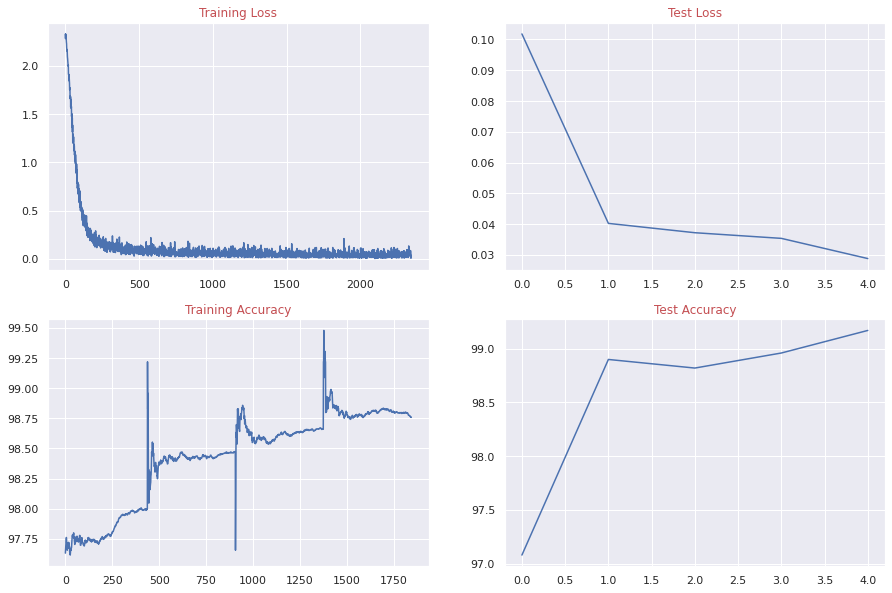

In [54]:
plot_metrics(train_metric, test_metric)

In [55]:
EPOCHS = 5
exp_name = 'Only l1'

trainer = Trainer(model,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
train_metric, test_metric = trainer.train(l1_lambda=5e-4, l2_lambda=0)

# save the metrics in dictionary

metric_values[exp_name] = (train_metric, test_metric)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


Loss=0.08814287930727005 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9905/10000 (99.05%)

EPOCH: 1
learning rate  [2.5e-05]


Loss=0.05174848437309265 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 37.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH: 2
learning rate  [0.0005]


Loss=0.004628837574273348 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 37.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9926/10000 (99.26%)

EPOCH: 3
learning rate  [0.0005]


Loss=0.003220072714611888 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 36.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)

EPOCH: 4
learning rate  [0.0005]


Loss=0.033777184784412384 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 37.41it/s]



Test set: Average loss: 0.0247, Accuracy: 9927/10000 (99.27%)



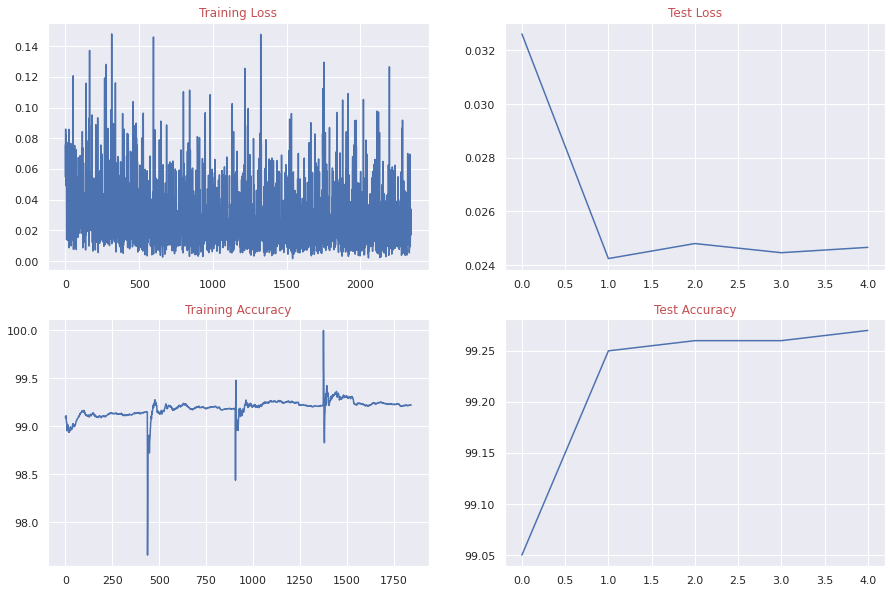

In [62]:
plot_metrics(train_metric, test_metric)

In [57]:
metric_values.keys()

dict_keys(['no-l1 & l2', 'Only l1'])

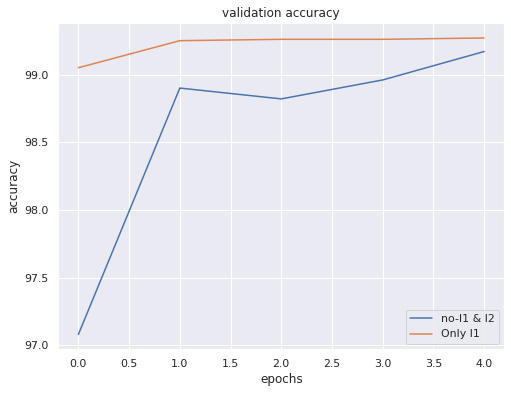

In [61]:
plt.figure(figsize=(8,6))
plt.title('validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
for idx,exp_name in enumerate(metric_values.keys()):
  train_metric,test_metric = metric_values[exp_name]
  train_acc,train_loss = train_metric
  test_acc,test_loss = test_metric
  plt.plot(test_acc,label='{}'.format(exp_name))
plt.legend()
plt.show()

Text(0.5, 1.0, 'Test Accuracy')

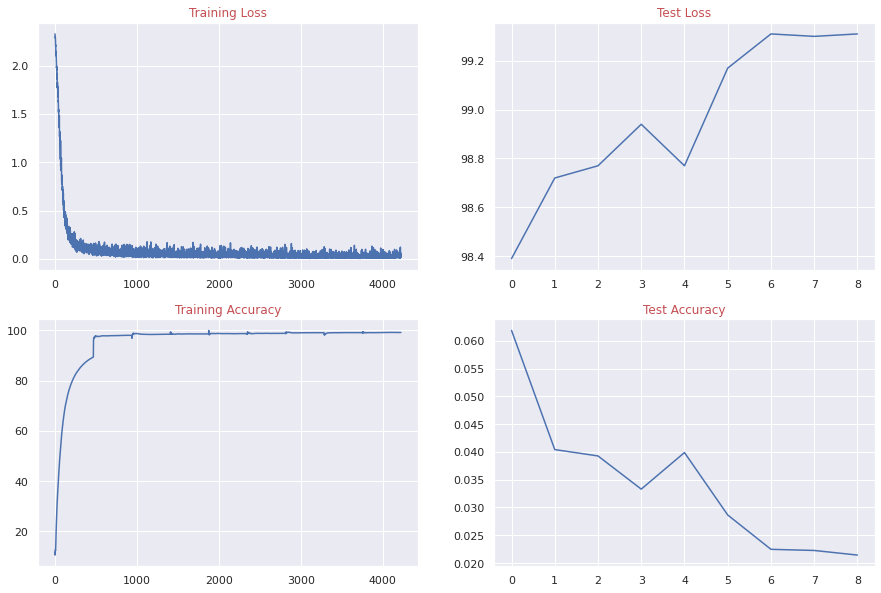

In [23]:
# # Plot Error and accuracy
# # Plot the accuracy and loss curves. 
# (train_acc, train_losses) = train_metric
# (test_acc, test_losses) = test_metric

# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set()
# # plt.style.use("dark_background")
# fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss",color='r')
# axs[1, 0].plot(train_acc)
# axs[1, 0].set_title("Training Accuracy",color='r')
# axs[0, 1].plot(test_losses)
# axs[0, 1].set_title("Test Loss",color='r')
# axs[1, 1].plot(test_acc)
# axs[1, 1].set_title("Test Accuracy", color='r')

In [16]:
# from torch.optim.lr_scheduler import StepLR

# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.05)


# comb_train_losses = []
# comb_train_acc    = []
# comb_test_losses  = []
# comb_test_acc     = []
# EPOCHS = 10
# for epoch in range(EPOCHS):
    
#     print("EPOCH:", epoch)
#     print('learning rate ', scheduler.get_lr())

#     trainer = Trainer(model,device,train_loader,test_loader,optimizer,epoch)

#     train_ac, train_los = trainer.train_mod()
#     scheduler.step()    
#     test_ac, test_los = trainer.test_mod()

#     comb_train_losses.extend(train_los)
#     comb_train_acc.extend(train_ac)
#     comb_test_losses.extend(test_los)
#     comb_test_acc.extend(test_ac)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


Loss=0.07515354454517365 Batch_id=468 Accuracy=87.86: 100%|██████████| 469/469 [00:11<00:00, 39.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9849/10000 (98.49%)

EPOCH: 1
learning rate  [0.01]


Loss=0.04480471834540367 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:11<00:00, 39.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9881/10000 (98.81%)

EPOCH: 2
learning rate  [0.01]


Loss=0.02029491402208805 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:11<00:00, 39.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9889/10000 (98.89%)

EPOCH: 3
learning rate  [0.01]


Loss=0.013025205582380295 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:12<00:00, 38.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9908/10000 (99.08%)

EPOCH: 4
learning rate  [0.01]


Loss=0.07046522945165634 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:12<00:00, 38.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9929/10000 (99.29%)

EPOCH: 5
learning rate  [0.01]


Loss=0.11041205376386642 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:11<00:00, 39.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9912/10000 (99.12%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.016590584069490433 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:11<00:00, 39.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9923/10000 (99.23%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.015234850347042084 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 39.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.023671194911003113 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 39.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9927/10000 (99.27%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.10647985339164734 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.87it/s]



Test set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)



Text(0.5, 1.0, 'Test Accuracy')

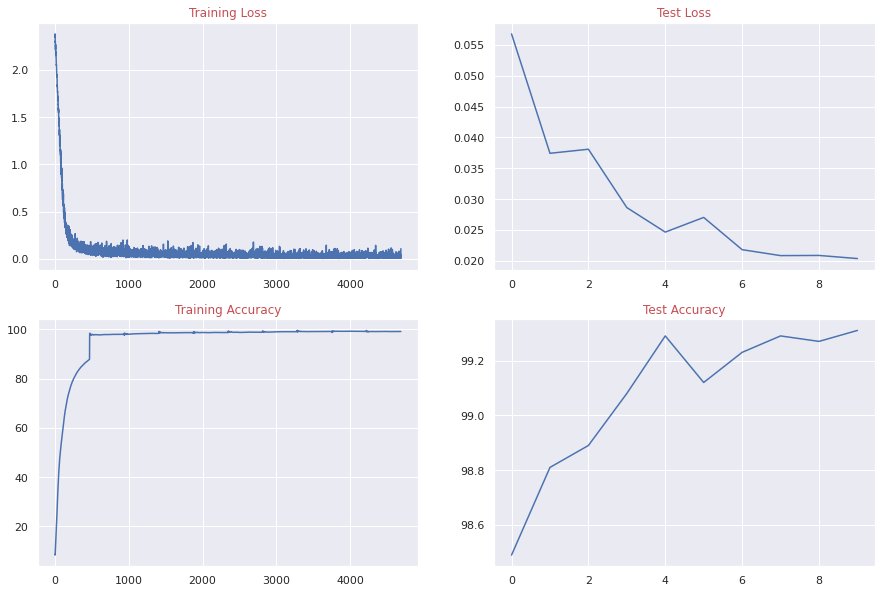

In [17]:
# Plot Error and accuracy
# Plot the accuracy and loss curves. 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# plt.style.use("dark_background")
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(comb_train_losses)
axs[0, 0].set_title("Training Loss",color='r')
axs[1, 0].plot(comb_train_acc)
axs[1, 0].set_title("Training Accuracy",color='r')
axs[0, 1].plot(comb_test_losses)
axs[0, 1].set_title("Test Loss",color='r')
axs[1, 1].plot(comb_test_acc)
axs[1, 1].set_title("Test Accuracy", color='r')

In [ ]:
# # Train Function

# # Train and Test Functuions
# from tqdm import tqdm


# def train(model, device, train_loader, optimizer, epoch):
#   train_losses = []
#   train_acc = []
#   model.train()
#   pbar = tqdm(train_loader)
#   correct = 0
#   processed = 0
#   for batch_idx, (data, target) in enumerate(pbar):
#     # get samples
#     data, target = data.to(device), target.to(device)

#     # Init
#     optimizer.zero_grad()
#     # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
#     # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

#     # Predict
#     y_pred = model(data)

#     # Calculate loss
#     loss = F.nll_loss(y_pred, target)
    
#     train_losses.append(loss)

#     # Backpropagation
#     loss.backward()
#     optimizer.step()

#     # Update pbar-tqdm
    
#     pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#     correct += pred.eq(target.view_as(pred)).sum().item()
#     processed += len(data)

#     pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
#     train_acc.append(100*correct/processed)
#   return (train_acc,train_losses)

